In [2]:
 #We'll be using TF 2.1 and torchaudio

try:
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf
!pip install soundfile                    #to save wav files
!pip install --no-deps torchaudio==0.5.0

     |████████████████████████████████| 3.2 MB 8.7 MB/s 


In [ ]:
#Connecting Drive to save model checkpoints during training and to use custom data, uncomment if needed

# import os
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
#Imports

from __future__ import print_function, division
from glob import glob
import scipy
import soundfile as sf
import matplotlib.pyplot as plt
from IPython.display import clear_output
from tensorflow.keras.layers import Embedding, Input, Dense, Reshape, Flatten, Concatenate, Conv2D, Conv2DTranspose, GlobalAveragePooling2D, UpSampling2D, LeakyReLU, ReLU, Add, Multiply, Lambda, Dot, BatchNormalization, Activation, ZeroPadding2D, Cropping2D, Cropping1D
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import TruncatedNormal, he_normal
import tensorflow.keras.backend as K
import datetime
import numpy as np
import random
import matplotlib.pyplot as plt
import collections
from PIL import Image
from skimage.transform import resize
import imageio
import librosa
import librosa.display
from librosa.feature import melspectrogram
import os
import time
import IPython

In [4]:
#Hyperparameters

hop=80               #hop size (window size = 6*hop)
sr=22050              #sampling rate
min_level_db=-100     #reference values to normalize data
ref_level_db=20

shape=24              #length of time axis of split specrograms to feed to generator            
vec_len=128           #length of vector generated by siamese vector
bs = 16               #batch size
delta = 2.            #constant for siamese loss

In [5]:
#There seems to be a problem with Tensorflow STFT, so we'll be using pytorch to handle offline mel-spectrogram generation and waveform reconstruction
#For waveform reconstruction, a gradient-based method is used:

""" ********************NOTE: This is used for mel-spectrogram generation through torchaudio and waveform reconstruction through a gradient based method. It's offline; this means, it's
used during training. CONSIDER if it will be necessary to alter the waveform reconstruction if extra input (encoding) is added. """

''' Decorsière, Rémi, Peter L. Søndergaard, Ewen N. MacDonald, and Torsten Dau. 
"Inversion of auditory spectrograms, traditional spectrograms, and other envelope representations." 
IEEE/ACM Transactions on Audio, Speech, and Language Processing 23, no. 1 (2014): 46-56.'''

#ORIGINAL CODE FROM https://github.com/yoyololicon/spectrogram-inversion

import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
from functools import partial
import math
import heapq
from torchaudio.transforms import MelScale, Spectrogram

torch.set_default_tensor_type('torch.cuda.FloatTensor') #Requires GPU

specobj = Spectrogram(n_fft=6*hop, win_length=6*hop, hop_length=hop, pad=0, power=2, normalized=True) #Transform that creates spectrogram from audio signal
specfunc = specobj.forward 
melobj = MelScale(n_mels=hop, sample_rate=sr, f_min=0.) #Turns STFT into a mel frequency STFT
melfunc = melobj.forward

def melspecfunc(waveform): #function that transforms audio file into spectrogram
  specgram = specfunc(waveform)
  mel_specgram = melfunc(specgram)
  return mel_specgram

def spectral_convergence(input, target): #Unsure what this is. I assume it's a method for calculating spectral difference
    return 20 * ((input - target).norm().log10() - target.norm().log10())

def GRAD(spec, transform_fn, samples=None, init_x0=None, maxiter=1000, tol=1e-6, verbose=1, evaiter=10, lr=0.003): #For waveform reconstruction, a gradient-based method is used:

    spec = torch.Tensor(spec) #takes in spectrogram
    samples = (spec.shape[-1]*hop)-hop #takes last dimension an

    if init_x0 is None:
        init_x0 = spec.new_empty((1,samples)).normal_(std=1e-6)
    x = nn.Parameter(init_x0)
    T = spec

    criterion = nn.L1Loss()
    optimizer = torch.optim.Adam([x], lr=lr)

    bar_dict = {}
    metric_func = spectral_convergence
    bar_dict['spectral_convergence'] = 0
    metric = 'spectral_convergence'

    init_loss = None
    with tqdm(total=maxiter, disable=not verbose) as pbar:
        for i in range(maxiter):
            optimizer.zero_grad()
            V = transform_fn(x)
            loss = criterion(V, T)
            loss.backward()
            optimizer.step()
            lr = lr*0.9999
            for param_group in optimizer.param_groups:
              param_group['lr'] = lr

            if i % evaiter == evaiter - 1:
                with torch.no_grad():
                    V = transform_fn(x)
                    bar_dict[metric] = metric_func(V, spec).item()
                    l2_loss = criterion(V, spec).item()
                    pbar.set_postfix(**bar_dict, loss=l2_loss)
                    pbar.update(evaiter)

    return x.detach().view(-1).cpu() #detach returns new tensor detached from current graph, with a different shape

def normalize(S):
  return np.clip((((S - min_level_db) / -min_level_db)*2.)-1., -1, 1) #-1,1 normalization

def denormalize(S):
  return (((np.clip(S, -1, 1)+1.)/2.) * -min_level_db) + min_level_db #denormalization

def prep(wv,hop=80):
  S = np.array(torch.squeeze(melspecfunc(torch.Tensor(wv).view(1,-1))).detach().cpu()) #I believe this is for online spectrogram creation. Transforms tensor
  S = librosa.power_to_db(S)-ref_level_db #by changing shape, turning it into mel, squeezing it, detaching from graph, operating in cpu and turning into np.
  return normalize(S) #it then transforms it to db 

def deprep(S):
  S = denormalize(S)+ref_level_db
  S = librosa.db_to_power(S)
  wv = GRAD(np.expand_dims(S,0), melspecfunc, maxiter=2000, evaiter=10, tol=1e-8) #reconstruction of waveform through denormalisation, return to power and gradient methdo
  return np.array(np.squeeze(wv))

In [6]:
#Helper functions

#Generate spectrograms from waveform array
#MAYBE WE CAN ADD ENCODINGS HERE
def tospec(data):
  specs=np.empty(data.shape[0], dtype=object) #return array of certain size without initializing entries
  for i in range(data.shape[0]):
    x = data[i]
    S=prep(x)
    S = np.array(S, dtype=np.float32)
    specs[i]=np.expand_dims(S, -1)
  print(specs.shape)
  return specs

#Generate multiple spectrograms with a determined length from single wav file
def tospeclong(path, length=4*22050):
  x, sr = librosa.load(path,sr=22050)
  x,_ = librosa.effects.trim(x)
  loudls = librosa.effects.split(x, top_db=50)
  xls = np.array([])
  for interv in loudls:
    xls = np.concatenate((xls,x[interv[0]:interv[1]]))
  x = xls
  num = x.shape[0]//length
  specs=np.empty(num, dtype=object)
  for i in range(num-1):
    a = x[i*length:(i+1)*length]
    S = prep(a)
    S = np.array(S, dtype=np.float32)
    try:
      sh = S.shape
      specs[i]=S
    except AttributeError:
      print('spectrogram failed')
  print(specs.shape)
  return specs

#Waveform array from path of folder containing wav files
def audio_array(path):
  ls = glob(f'{path}/*.wav')
  adata = []
  for i in range(len(ls)):
    x, sr = tf.audio.decode_wav(tf.io.read_file(ls[i]), 1)
    x = np.array(x, dtype=np.float32)
    adata.append(x)
  return np.array(adata)

#Concatenate spectrograms in array along the time axis
def testass(a):
  but=False
  con = np.array([])
  nim = a.shape[0]
  for i in range(nim):
    im = a[i]
    im = np.squeeze(im)
    if not but:
      con=im
      but=True
    else:
      con = np.concatenate((con,im), axis=1)
  return np.squeeze(con)

#Split spectrograms in chunks with equal size
def splitcut(data):
  ls = []
  mini = 0
  minifinal = 10*shape                                                              #max spectrogram length
  for i in range(data.shape[0]-1):
    if data[i].shape[1]<=data[i+1].shape[1]:
      mini = data[i].shape[1]
    else:
      mini = data[i+1].shape[1]
    if mini>=3*shape and mini<minifinal:
      minifinal = mini
  for i in range(data.shape[0]):
    x = data[i]
    if x.shape[1]>=3*shape:
      for n in range(x.shape[1]//minifinal):
        ls.append(x[:,n*minifinal:n*minifinal+minifinal,:])
      ls.append(x[:,-minifinal:,:])
  return np.array(ls)

def splitcut_target(data):
  ls = []
  mini = 0
  minifinal = 10*shape                                                              #max spectrogram length
  for i in range(data.shape[0]-1):
    if data[i].shape[1]<=data[i+1].shape[1]:
      mini = data[i].shape[1]
    else:
      mini = data[i+1].shape[1]
    if mini>=3*shape and mini<minifinal:
      minifinal = mini
  for i in range(data.shape[0]):
    x = data[i]
    if x.shape[1]>=3*shape:
      for n in range(x.shape[1]//minifinal):
        ls.append(x[:,n*minifinal:n*minifinal+minifinal,:])
      ls.append(x[:,-minifinal:,:])
  return np.array(ls)

  

In [ ]:
"""#IMPORT STUFF FOR ONEHOT ENCODING
import pandas as pd
import sklearn
from sklearn.preprocessing import OneHotEncoder
from tensorflow import one_hot
"""

In [1]:
speaker_ids = {'F01':0, 'F03':1, 'F04':2, 'M01':3, 'M02':4, 'M03':5, 'M04':6, 'M05': 7}

def create_speaker_vector(speaker_index):
  speaker_vector = np.full((240, 1), speaker_index)
  return speaker_vector 

#print(create_speaker_vector(2))

F01_embedding = create_speaker_vector(0)
F03_embedding = create_speaker_vector(1)
M01_embedding = create_speaker_vector(3)

print(M01_embedding.shape)
print(F03_embedding.shape)

NameError: ignored

In [8]:
#Generating Mel-Spectrogram dataset (Uncomment where needed)
#adata: source spectrograms
#bdata: target spectrograms

#CONTROL1

awv = audio_array('/content/INP')                               #get waveform array from folder containing wav files
aspec = tospec(awv)                                                            #get spectrogram array
adata = splitcut(aspec)      
print(adata.shape)



#DYSARTHRIC 1

m01wv = audio_array('/content/OUT')
#f03wv = audio_array('/content/OUTP/F02')

m01spec = tospec(m01wv)
#f03spec = tospec(f03wv)

bdata = splitcut(m01spec)

#print(f"Shape of M01 spec array: {m01data.shape}")
#f03data = splitcut(f03spec)
#print(f"Shape of F03 spec array: {f03data.shape}")
"""
for i in m01data:
  for elem in i:
    np.concatenate((elem, m01_final_embed), axis=0)

  

for i in f03data:
  for elem in i:
    np.concatenate((elem, f03_final_emb), axis=0)


all_bdata = np.append(f03data, f01data, axis=0)
print(all_bdata.shape)"""

(1,)
(6, 80, 240, 1)
(1,)


'\nfor i in m01data:\n  for elem in i:\n    np.concatenate((elem, m01_final_embed), axis=0)\n\n  \n\nfor i in f03data:\n  for elem in i:\n    np.concatenate((elem, f03_final_emb), axis=0)\n\n\nall_bdata = np.append(f03data, f01data, axis=0)\nprint(all_bdata.shape)'

In [9]:
#Creating Tensorflow Datasets

@tf.function
def proc(x):
  return tf.image.random_crop(x, size=[hop, 3*shape, 1])

dsa = tf.data.Dataset.from_tensor_slices(adata).repeat(50).map(proc, num_parallel_calls=tf.data.experimental.AUTOTUNE).shuffle(10000).batch(bs, drop_remainder=True)
dsb = tf.data.Dataset.from_tensor_slices(bdata).repeat(50).map(proc, num_parallel_calls=tf.data.experimental.AUTOTUNE).shuffle(10000).batch(bs, drop_remainder=True)

In [10]:
#Adding Spectral Normalization to convolutional layers

from tensorflow.python.keras.utils import conv_utils
from tensorflow.python.ops import array_ops
from tensorflow.python.ops import math_ops
from tensorflow.python.ops import sparse_ops
from tensorflow.python.ops import gen_math_ops
from tensorflow.python.ops import standard_ops
from tensorflow.python.eager import context
from tensorflow.python.framework import tensor_shape

def l2normalize(v, eps=1e-12):
    return v / (tf.norm(v) + eps)


class ConvSN2D(tf.keras.layers.Conv2D):

    def __init__(self, filters, kernel_size, power_iterations=1, **kwargs):
        super(ConvSN2D, self).__init__(filters, kernel_size, **kwargs)
        self.power_iterations = power_iterations


    def build(self, input_shape):
        super(ConvSN2D, self).build(input_shape)

        if self.data_format == 'channels_first':
            channel_axis = 1
        else:
            channel_axis = -1

        self.u = self.add_weight(self.name + '_u',
            shape=tuple([1, self.kernel.shape.as_list()[-1]]), 
            initializer=tf.initializers.RandomNormal(0, 1),
            trainable=False
        )

    def compute_spectral_norm(self, W, new_u, W_shape):
        for _ in range(self.power_iterations):

            new_v = l2normalize(tf.matmul(new_u, tf.transpose(W)))
            new_u = l2normalize(tf.matmul(new_v, W))
            
        sigma = tf.matmul(tf.matmul(new_v, W), tf.transpose(new_u))
        W_bar = W/sigma

        with tf.control_dependencies([self.u.assign(new_u)]):
          W_bar = tf.reshape(W_bar, W_shape)

        return W_bar


    def call(self, inputs):
        W_shape = self.kernel.shape.as_list()
        W_reshaped = tf.reshape(self.kernel, (-1, W_shape[-1]))
        new_kernel = self.compute_spectral_norm(W_reshaped, self.u, W_shape)
        outputs = self._convolution_op(inputs, new_kernel)

        if self.use_bias:
            if self.data_format == 'channels_first':
                    outputs = tf.nn.bias_add(outputs, self.bias, data_format='NCHW')
            else:
                outputs = tf.nn.bias_add(outputs, self.bias, data_format='NHWC')
        if self.activation is not None:
            return self.activation(outputs)

        return outputs

class ConvSN2DTranspose(tf.keras.layers.Conv2DTranspose):

    def __init__(self, filters, kernel_size, power_iterations=1, **kwargs):
        super(ConvSN2DTranspose, self).__init__(filters, kernel_size, **kwargs)
        self.power_iterations = power_iterations


    def build(self, input_shape):
        super(ConvSN2DTranspose, self).build(input_shape)

        if self.data_format == 'channels_first':
            channel_axis = 1
        else:
            channel_axis = -1

        self.u = self.add_weight(self.name + '_u',
            shape=tuple([1, self.kernel.shape.as_list()[-1]]), 
            initializer=tf.initializers.RandomNormal(0, 1),
            trainable=False
        )

    def compute_spectral_norm(self, W, new_u, W_shape):
        for _ in range(self.power_iterations):

            new_v = l2normalize(tf.matmul(new_u, tf.transpose(W)))
            new_u = l2normalize(tf.matmul(new_v, W))
            
        sigma = tf.matmul(tf.matmul(new_v, W), tf.transpose(new_u))
        W_bar = W/sigma

        with tf.control_dependencies([self.u.assign(new_u)]):
          W_bar = tf.reshape(W_bar, W_shape)

        return W_bar

    def call(self, inputs):
        W_shape = self.kernel.shape.as_list()
        W_reshaped = tf.reshape(self.kernel, (-1, W_shape[-1]))
        new_kernel = self.compute_spectral_norm(W_reshaped, self.u, W_shape)

        inputs_shape = array_ops.shape(inputs)
        batch_size = inputs_shape[0]
        if self.data_format == 'channels_first':
          h_axis, w_axis = 2, 3
        else:
          h_axis, w_axis = 1, 2

        height, width = inputs_shape[h_axis], inputs_shape[w_axis]
        kernel_h, kernel_w = self.kernel_size
        stride_h, stride_w = self.strides

        if self.output_padding is None:
          out_pad_h = out_pad_w = None
        else:
          out_pad_h, out_pad_w = self.output_padding

        out_height = conv_utils.deconv_output_length(height,
                                                    kernel_h,
                                                    padding=self.padding,
                                                    output_padding=out_pad_h,
                                                    stride=stride_h,
                                                    dilation=self.dilation_rate[0])
        out_width = conv_utils.deconv_output_length(width,
                                                    kernel_w,
                                                    padding=self.padding,
                                                    output_padding=out_pad_w,
                                                    stride=stride_w,
                                                    dilation=self.dilation_rate[1])
        if self.data_format == 'channels_first':
          output_shape = (batch_size, self.filters, out_height, out_width)
        else:
          output_shape = (batch_size, out_height, out_width, self.filters)

        output_shape_tensor = array_ops.stack(output_shape)
        outputs = K.conv2d_transpose(
            inputs,
            new_kernel,
            output_shape_tensor,
            strides=self.strides,
            padding=self.padding,
            data_format=self.data_format,
            dilation_rate=self.dilation_rate)

        if not context.executing_eagerly():
          out_shape = self.compute_output_shape(inputs.shape)
          outputs.set_shape(out_shape)

        if self.use_bias:
          outputs = tf.nn.bias_add(
              outputs,
              self.bias,
              data_format=conv_utils.convert_data_format(self.data_format, ndim=4))

        if self.activation is not None:
          return self.activation(outputs)
        return outputs  

class DenseSN(Dense):
    def build(self, input_shape):
        super(DenseSN, self).build(input_shape)

        self.u = self.add_weight(self.name + '_u',
            shape=tuple([1, self.kernel.shape.as_list()[-1]]), 
            initializer=tf.initializers.RandomNormal(0, 1),
            trainable=False)
        
    def compute_spectral_norm(self, W, new_u, W_shape):
        new_v = l2normalize(tf.matmul(new_u, tf.transpose(W)))
        new_u = l2normalize(tf.matmul(new_v, W))
        sigma = tf.matmul(tf.matmul(new_v, W), tf.transpose(new_u))
        W_bar = W/sigma
        with tf.control_dependencies([self.u.assign(new_u)]):
          W_bar = tf.reshape(W_bar, W_shape)
        return W_bar
        
    def call(self, inputs):
        W_shape = self.kernel.shape.as_list()
        W_reshaped = tf.reshape(self.kernel, (-1, W_shape[-1]))
        new_kernel = self.compute_spectral_norm(W_reshaped, self.u, W_shape)
        rank = len(inputs.shape)
        if rank > 2:
          outputs = standard_ops.tensordot(inputs, new_kernel, [[rank - 1], [0]])
          if not context.executing_eagerly():
            shape = inputs.shape.as_list()
            output_shape = shape[:-1] + [self.units]
            outputs.set_shape(output_shape)
        else:
          inputs = math_ops.cast(inputs, self._compute_dtype)
          if K.is_sparse(inputs):
            outputs = sparse_ops.sparse_tensor_dense_matmul(inputs, new_kernel)
          else:
            outputs = gen_math_ops.mat_mul(inputs, new_kernel)
        if self.use_bias:
          outputs = tf.nn.bias_add(outputs, self.bias)
        if self.activation is not None:
          return self.activation(outputs)
        return outputs


In [57]:
#Networks Architecture

init = tf.keras.initializers.he_uniform()

def conv2d(layer_input, filters, kernel_size=4, strides=2, padding='same', leaky=True, bnorm=True, sn=True):
  if leaky:
    Activ = LeakyReLU(alpha=0.2)
  else:
    Activ = ReLU()
  if sn:
    d = ConvSN2D(filters, kernel_size=kernel_size, strides=strides, padding=padding, kernel_initializer=init, use_bias=False)(layer_input)
  else:
    d = Conv2D(filters, kernel_size=kernel_size, strides=strides, padding=padding, kernel_initializer=init, use_bias=False)(layer_input)
  if bnorm:
    d = BatchNormalization()(d)
  d = Activ(d)
  return d

def deconv2d(layer_input, layer_res, filters, kernel_size=4, conc=True, scalev=False, bnorm=True, up=True, padding='same', strides=2):
  if up:
    u = UpSampling2D((1,2))(layer_input)
    u = ConvSN2D(filters, kernel_size, strides=(1,1), kernel_initializer=init, use_bias=False, padding=padding)(u)
  else:
    u = ConvSN2DTranspose(filters, kernel_size, strides=strides, kernel_initializer=init, use_bias=False, padding=padding)(layer_input)
  if bnorm:
    u = BatchNormalization()(u)
  u = LeakyReLU(alpha=0.2)(u)
  if conc:
    u = Concatenate()([u,layer_res])
  return u

#Extract function: splitting spectrograms
def extract_image(im):
  im1 = Cropping2D(((0,0), (0, 2*(im.shape[2]//3))))(im)
  im2 = Cropping2D(((0,0), (im.shape[2]//3,im.shape[2]//3)))(im)
  im3 = Cropping2D(((0,0), (2*(im.shape[2]//3), 0)))(im)
  return im1,im2,im3

#Assemble function: concatenating spectrograms
def assemble_image(lsim):
  im1,im2,im3 = lsim
  imh = Concatenate(2)([im1,im2,im3])
  return imh

#U-NET style architecture
def build_generator(input_shape, speaker_id):
  h,w,c = input_shape
  inp = Input(shape=input_shape)
  speaker_vector = np.full((w,c), speaker_id)
  speaker_v_input = Input(shape=speaker_vector)
  embedding_out = tf.keras.layers.Embedding(2, 64)(speaker_v_input)
  #inp = tf.concat([inp, embedding_out], axis=1)

  g0 = tf.keras.layers.ZeroPadding2D((0,1))(inp)#Add extra input
  g1 = conv2d(g0, 256, kernel_size=(h,3), strides=1, padding='valid')
  g2 = conv2d(g1, 256, kernel_size=(1,9), strides=(1,2))
  g3 = conv2d(g2, 256, kernel_size=(1,7), strides=(1,2))
  #upscaling
  g4 = deconv2d(g3,g2, 256, kernel_size=(1,7), strides=(1,2))
  g5 = deconv2d(g4,g1, 256, kernel_size=(1,9), strides=(1,2), bnorm=False)
  g6 = ConvSN2DTranspose(1, kernel_size=(h,1), strides=(1,1), kernel_initializer=init, padding='valid', activation='tanh')(g5)
  return Model([inp, embedding_out],g6, name='G')

#Siamese Network
def build_siamese(input_shape):
  h,w,c = input_shape
  inp = Input(shape=input_shape)
  g1 = conv2d(inp, 256, kernel_size=(h,3), strides=1, padding='valid', sn=False)
  g2 = conv2d(g1, 256, kernel_size=(1,9), strides=(1,2), sn=False)
  g3 = conv2d(g2, 256, kernel_size=(1,7), strides=(1,2), sn=False)
  g4 = Flatten()(g3)
  g5 = Dense(vec_len)(g4)
  return Model(inp, g5, name='S')

#Discriminator (Critic) Network
def build_critic(input_shape):
  h,w,c = input_shape
  inp = Input(shape=input_shape)
  g1 = conv2d(inp, 512, kernel_size=(h,3), strides=1, padding='valid', bnorm=False)
  g2 = conv2d(g1, 512, kernel_size=(1,9), strides=(1,2), bnorm=False)
  g3 = conv2d(g2, 512, kernel_size=(1,7), strides=(1,2), bnorm=False)
  g4 = Flatten()(g3)
  g4 = DenseSN(1, kernel_initializer=init)(g4)
  return Model(inp, g4, name='C')

In [58]:
#Load past models from path to resume training or test
def load(path):
  gen = build_generator((hop,shape,1))
  siam = build_siamese((hop,shape,1))
  critic = build_critic((hop,3*shape,1))
  gen.load_weights(path+'/gen.h5')
  critic.load_weights(path+'/critic.h5')
  siam.load_weights(path+'/siam.h5')
  return gen,critic,siam

#Build models
def build():
  gen = build_generator((hop,shape,1), speaker_id=1)
  siam = build_siamese((hop,shape,1))
  critic = build_critic((hop,3*shape,1))                                          #the discriminator accepts as input spectrograms of triple the width of those generated by the generator
  return gen,critic,siam

#Generate a random batch to display current training results
def testgena():
  sw = True
  while sw:
    a = np.random.choice(aspec)
    if a.shape[1]//shape!=1:
      sw=False
  dsa = []
  if a.shape[1]//shape>6:
    num=6
  else:
    num=a.shape[1]//shape
  rn = np.random.randint(a.shape[1]-(num*shape))
  for i in range(num):
    im = a[:,rn+(i*shape):rn+(i*shape)+shape]
    im = np.reshape(im, (im.shape[0],im.shape[1],1))
    dsa.append(im)
  return np.array(dsa, dtype=np.float32)

#Show results mid-training
def save_test_image_full(path):
  a = testgena()
  print(a.shape)
  ab = gen(a, training=False)
  ab = testass(ab)
  a = testass(a)
  abwv = deprep(ab)
  awv = deprep(a)
  sf.write(path+'/new_file.wav', abwv, sr)
  IPython.display.display(IPython.display.Audio(np.squeeze(abwv), rate=sr))
  IPython.display.display(IPython.display.Audio(np.squeeze(awv), rate=sr))
  fig, axs = plt.subplots(ncols=2)
  axs[0].imshow(np.flip(a, -2), cmap=None)
  axs[0].axis('off')
  axs[0].set_title('Source')
  axs[1].imshow(np.flip(ab, -2), cmap=None)
  axs[1].axis('off')
  axs[1].set_title('Generated')
  plt.show()

#Save in training loop
def save_end(epoch,gloss,closs,mloss,n_save=3,save_path='../content/'):                 #use custom save_path (i.e. Drive '../content/drive/My Drive/')
  if epoch % n_save == 0:
    print('Saving...')
    path = f'{save_path}/MELGANVC-{str(gloss)[:9]}-{str(closs)[:9]}-{str(mloss)[:9]}'
    os.mkdir(path)
    gen.save_weights(path+'/gen.h5')
    critic.save_weights(path+'/critic.h5')
    siam.save_weights(path+'/siam.h5')
    save_test_image_full(path)

In [59]:
#Losses

def mae(x,y):
  return tf.reduce_mean(tf.abs(x-y))

def mse(x,y):
  return tf.reduce_mean((x-y)**2)

def loss_travel(sa,sab,sa1,sab1):
  l1 = tf.reduce_mean(((sa-sa1) - (sab-sab1))**2)
  l2 = tf.reduce_mean(tf.reduce_sum(-(tf.nn.l2_normalize(sa-sa1, axis=[-1]) * tf.nn.l2_normalize(sab-sab1, axis=[-1])), axis=-1))
  return l1+l2

def loss_siamese(sa,sa1):
  logits = tf.sqrt(tf.reduce_sum((sa-sa1)**2, axis=-1, keepdims=True))
  return tf.reduce_mean(tf.square(tf.maximum((delta - logits), 0)))

def d_loss_f(fake):
  return tf.reduce_mean(tf.maximum(1 + fake, 0))

def d_loss_r(real):
  return tf.reduce_mean(tf.maximum(1 - real, 0))

def g_loss_f(fake):
  return tf.reduce_mean(- fake)

In [60]:
#Get models and optimizers
def get_networks(shape, load_model=False, path=None):
  if not load_model:
    gen,critic,siam = build()
  else:
    gen,critic,siam = load(path)
  print('Built networks')

  opt_gen = Adam(0.0001, 0.5)
  opt_disc = Adam(0.0001, 0.5)

  return gen,critic,siam, [opt_gen,opt_disc]

#Set learning rate
def update_lr(lr):
  opt_gen.learning_rate = lr
  opt_disc.learning_rate = lr

In [61]:
#Training Functions

#Train Generator, Siamese and Critic
@tf.function
def train_all(a,b):
  #splitting spectrogram in 3 parts
  aa,aa2,aa3 = extract_image(a) 
  bb,bb2,bb3 = extract_image(b)

  with tf.GradientTape() as tape_gen, tf.GradientTape() as tape_disc:

    #translating A to B
    fab = gen(aa, training=True)
    fab2 = gen(aa2, training=True)
    fab3 = gen(aa3, training=True)
    #identity mapping B to B                                                        COMMENT THESE 3 LINES IF THE IDENTITY LOSS TERM IS NOT NEEDED
    fid = gen(bb, training=True) 
    fid2 = gen(bb2, training=True)
    fid3 = gen(bb3, training=True)
    #concatenate/assemble converted spectrograms
    fabtot = assemble_image([fab,fab2,fab3])

    #feed concatenated spectrograms to critic
    cab = critic(fabtot, training=True)
    cb = critic(b, training=True)
    #feed 2 pairs (A,G(A)) extracted spectrograms to Siamese
    sab = siam(fab, training=True)
    sab2 = siam(fab3, training=True)
    sa = siam(aa, training=True)
    sa2 = siam(aa3, training=True)

    #identity mapping loss
    loss_id = (mae(bb,fid)+mae(bb2,fid2)+mae(bb3,fid3))/3.                         #loss_id = 0. IF THE IDENTITY LOSS TERM IS NOT NEEDED
    #travel loss
    loss_m = loss_travel(sa,sab,sa2,sab2)+loss_siamese(sa,sa2)
    #generator and critic losses
    loss_g = g_loss_f(cab)
    loss_dr = d_loss_r(cb)
    loss_df = d_loss_f(cab)
    loss_d = (loss_dr+loss_df)/2.
    #generator+siamese total loss
    lossgtot = loss_g+10.*loss_m+0.5*loss_id                                       #CHANGE LOSS WEIGHTS HERE  (COMMENT OUT +w*loss_id IF THE IDENTITY LOSS TERM IS NOT NEEDED)
  
  #computing and applying gradients
  grad_gen = tape_gen.gradient(lossgtot, gen.trainable_variables+siam.trainable_variables)
  opt_gen.apply_gradients(zip(grad_gen, gen.trainable_variables+siam.trainable_variables))

  grad_disc = tape_disc.gradient(loss_d, critic.trainable_variables)
  opt_disc.apply_gradients(zip(grad_disc, critic.trainable_variables))
  
  return loss_dr,loss_df,loss_g,loss_id

#Train Critic only
@tf.function
def train_d(a,b):
  aa,aa2,aa3 = extract_image(a)
  with tf.GradientTape() as tape_disc:

    fab = gen(aa, training=True)
    fab2 = gen(aa2, training=True)
    fab3 = gen(aa3, training=True)
    fabtot = assemble_image([fab,fab2,fab3])

    cab = critic(fabtot, training=True)
    cb = critic(b, training=True)

    loss_dr = d_loss_r(cb)
    loss_df = d_loss_f(cab)

    loss_d = (loss_dr+loss_df)/2.
  
  grad_disc = tape_disc.gradient(loss_d, critic.trainable_variables)
  opt_disc.apply_gradients(zip(grad_disc, critic.trainable_variables))

  return loss_dr,loss_df

In [62]:
#Training Loop

def train(epochs, batch_size=16, lr=0.0001, n_save=6, gupt=5):
  
  update_lr(lr)
  df_list = []
  dr_list = []
  g_list = []
  id_list = []
  c = 0
  g = 0
  
  for epoch in range(epochs):
        bef = time.time()
        
        for batchi,(a,b) in enumerate(zip(dsa,dsb)):
          
            if batchi%gupt==0:
              dloss_t,dloss_f,gloss,idloss = train_all(a,b)
            else:
              dloss_t,dloss_f = train_d(a,b)

            df_list.append(dloss_f)
            dr_list.append(dloss_t)
            g_list.append(gloss)
            id_list.append(idloss)
            c += 1
            g += 1

            if batchi%600==0:
                print(f'[Epoch {epoch}/{epochs}] [Batch {batchi}] [D loss f: {np.mean(df_list[-g:], axis=0)} ', end='')
                print(f'r: {np.mean(dr_list[-g:], axis=0)}] ', end='')
                print(f'[G loss: {np.mean(g_list[-g:], axis=0)}] ', end='')
                print(f'[ID loss: {np.mean(id_list[-g:])}] ', end='')
                print(f'[LR: {lr}]')
                g = 0
            nbatch=batchi

        print(f'Time/Batch {(time.time()-bef)/nbatch}')
        save_end(epoch,np.mean(g_list[-n_save*c:], axis=0),np.mean(df_list[-n_save*c:], axis=0),np.mean(id_list[-n_save*c:], axis=0),n_save=n_save)
        print(f'Mean D loss: {np.mean(df_list[-c:], axis=0)} Mean G loss: {np.mean(g_list[-c:], axis=0)} Mean ID loss: {np.mean(id_list[-c:], axis=0)}')
        c = 0
                      

In [63]:
#Build models and initialize optimizers

#If load_model=True, specify the path where the models are saved

gen,critic,siam, [opt_gen,opt_disc] = get_networks(shape, load_model=False, path='../content/drive/My Drive/')

TypeError: ignored

[Epoch 0/20] [Batch 0] [D loss f: 0.3823700547218323 r: 1.0024280548095703] [G loss: 0.6793856024742126] [ID loss: 0.10097344219684601] [LR: 0.0002]
[Epoch 0/20] [Batch 600] [D loss f: 0.5170603394508362 r: 0.6506401300430298] [G loss: 0.6594752073287964] [ID loss: 0.12393414974212646] [LR: 0.0002]
[Epoch 0/20] [Batch 1200] [D loss f: 0.5141641497612 r: 0.6859932541847229] [G loss: 0.6520172953605652] [ID loss: 0.11301996558904648] [LR: 0.0002]
[Epoch 0/20] [Batch 1800] [D loss f: 0.48465535044670105 r: 0.6858042478561401] [G loss: 0.6577489376068115] [ID loss: 0.11958225071430206] [LR: 0.0002]


  0%|          | 0/2000 [00:00<?, ?it/s]

Time/Batch 0.03310746829470093
Saving...
(6, 80, 24, 1)


100%|██████████| 2000/2000 [00:04<00:00, 440.74it/s, loss=0.000188, spectral_convergence=-41.7]


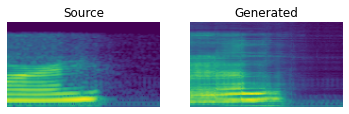

Mean D loss: 0.5076271295547485 Mean G loss: 0.651986837387085 Mean ID loss: 0.11849413067102432
[Epoch 1/20] [Batch 0] [D loss f: 0.5219653844833374 r: 0.6710072159767151] [G loss: 0.6251505017280579] [ID loss: 0.11644670367240906] [LR: 0.0002]
[Epoch 1/20] [Batch 600] [D loss f: 0.5095321536064148 r: 0.6847925186157227] [G loss: 0.6903286576271057] [ID loss: 0.11418024450540543] [LR: 0.0002]
[Epoch 1/20] [Batch 1200] [D loss f: 0.4962022006511688 r: 0.7136991620063782] [G loss: 0.7121887803077698] [ID loss: 0.11832496523857117] [LR: 0.0002]
[Epoch 1/20] [Batch 1800] [D loss f: 0.4898148477077484 r: 0.6963803172111511] [G loss: 0.697251558303833] [ID loss: 0.11104749143123627] [LR: 0.0002]


  0%|          | 0/2000 [00:00<?, ?it/s]

Time/Batch 0.03303808520355587
Saving...
(6, 80, 24, 1)


100%|██████████| 2000/2000 [00:04<00:00, 427.82it/s, loss=3.92e-7, spectral_convergence=-4.37]


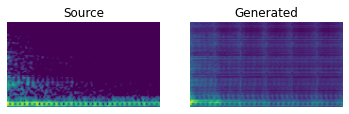

Mean D loss: 0.4991483986377716 Mean G loss: 0.69733065366745 Mean ID loss: 0.1140255257487297
[Epoch 2/20] [Batch 0] [D loss f: 0.502423882484436 r: 0.696421205997467] [G loss: 0.6825078725814819] [ID loss: 0.11124639213085175] [LR: 0.0002]
[Epoch 2/20] [Batch 600] [D loss f: 0.480564683675766 r: 0.701310396194458] [G loss: 0.6977960467338562] [ID loss: 0.11334467679262161] [LR: 0.0002]
[Epoch 2/20] [Batch 1200] [D loss f: 0.4927869737148285 r: 0.7084217071533203] [G loss: 0.665682852268219] [ID loss: 0.1115235909819603] [LR: 0.0002]
[Epoch 2/20] [Batch 1800] [D loss f: 0.4920249879360199 r: 0.7124888896942139] [G loss: 0.6752796769142151] [ID loss: 0.11699244379997253] [LR: 0.0002]


  0%|          | 0/2000 [00:00<?, ?it/s]

Time/Batch 0.0330440038739927
Saving...
(6, 80, 24, 1)


100%|██████████| 2000/2000 [00:04<00:00, 432.37it/s, loss=2.72e-5, spectral_convergence=-36.5]


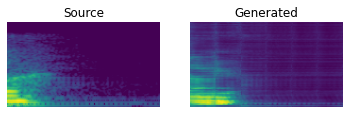

Mean D loss: 0.48827701807022095 Mean G loss: 0.6856920123100281 Mean ID loss: 0.11424463987350464
[Epoch 3/20] [Batch 0] [D loss f: 0.4873262345790863 r: 0.6992950439453125] [G loss: 0.7215341329574585] [ID loss: 0.11596335470676422] [LR: 0.0002]
[Epoch 3/20] [Batch 600] [D loss f: 0.4915754199028015 r: 0.711818516254425] [G loss: 0.6891937851905823] [ID loss: 0.11570031195878983] [LR: 0.0002]
[Epoch 3/20] [Batch 1200] [D loss f: 0.49599379301071167 r: 0.7248719334602356] [G loss: 0.6673552989959717] [ID loss: 0.11123871058225632] [LR: 0.0002]
[Epoch 3/20] [Batch 1800] [D loss f: 0.4624297618865967 r: 0.7381486296653748] [G loss: 0.7167437672615051] [ID loss: 0.11089103668928146] [LR: 0.0002]


  0%|          | 0/2000 [00:00<?, ?it/s]

Time/Batch 0.03304119563159354
Saving...
(6, 80, 24, 1)


100%|██████████| 2000/2000 [00:04<00:00, 419.29it/s, loss=0.000532, spectral_convergence=-34.6]


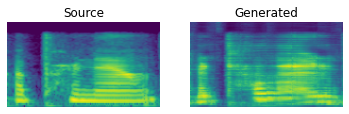

Mean D loss: 0.48486626148223877 Mean G loss: 0.694633424282074 Mean ID loss: 0.11181585490703583
[Epoch 4/20] [Batch 0] [D loss f: 0.49407869577407837 r: 0.7219786643981934] [G loss: 0.7153311371803284] [ID loss: 0.10697081685066223] [LR: 0.0002]
[Epoch 4/20] [Batch 600] [D loss f: 0.47920408844947815 r: 0.7459026575088501] [G loss: 0.6879573464393616] [ID loss: 0.10926643013954163] [LR: 0.0002]
[Epoch 4/20] [Batch 1200] [D loss f: 0.482012540102005 r: 0.7338976860046387] [G loss: 0.6759589314460754] [ID loss: 0.11256784945726395] [LR: 0.0002]
[Epoch 4/20] [Batch 1800] [D loss f: 0.47918760776519775 r: 0.7507790923118591] [G loss: 0.6676831245422363] [ID loss: 0.11323437839746475] [LR: 0.0002]


  0%|          | 0/2000 [00:00<?, ?it/s]

Time/Batch 0.033074464367574295
Saving...
(6, 80, 24, 1)


100%|██████████| 2000/2000 [00:04<00:00, 430.85it/s, loss=6.73e-8, spectral_convergence=4.36]


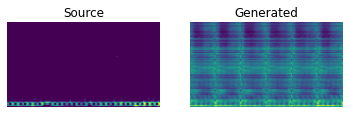

Mean D loss: 0.48015475273132324 Mean G loss: 0.6726870536804199 Mean ID loss: 0.11196066439151764
[Epoch 5/20] [Batch 0] [D loss f: 0.47994476556777954 r: 0.7648136615753174] [G loss: 0.6472660303115845] [ID loss: 0.11353765428066254] [LR: 0.0002]
[Epoch 5/20] [Batch 600] [D loss f: 0.4741044044494629 r: 0.7558405995368958] [G loss: 0.6640487909317017] [ID loss: 0.11089112609624863] [LR: 0.0002]
[Epoch 5/20] [Batch 1200] [D loss f: 0.48779210448265076 r: 0.7536599636077881] [G loss: 0.68196040391922] [ID loss: 0.11135826259851456] [LR: 0.0002]
[Epoch 5/20] [Batch 1800] [D loss f: 0.4702041745185852 r: 0.7496098875999451] [G loss: 0.6844872236251831] [ID loss: 0.10846278816461563] [LR: 0.0002]


  0%|          | 0/2000 [00:00<?, ?it/s]

Time/Batch 0.03303081519246951
Saving...
(6, 80, 24, 1)


100%|██████████| 2000/2000 [00:04<00:00, 415.15it/s, loss=1.61e-7, spectral_convergence=-2.25]


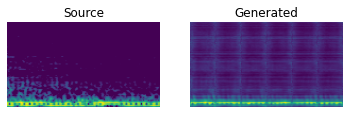

Mean D loss: 0.47761261463165283 Mean G loss: 0.6701110601425171 Mean ID loss: 0.1106271743774414
[Epoch 6/20] [Batch 0] [D loss f: 0.47862374782562256 r: 0.7656210660934448] [G loss: 0.630500078201294] [ID loss: 0.11293357610702515] [LR: 0.0002]
[Epoch 6/20] [Batch 600] [D loss f: 0.45903462171554565 r: 0.7650170922279358] [G loss: 0.6907114386558533] [ID loss: 0.1138613149523735] [LR: 0.0002]
[Epoch 6/20] [Batch 1200] [D loss f: 0.4626826047897339 r: 0.752254843711853] [G loss: 0.6902135014533997] [ID loss: 0.10986798256635666] [LR: 0.0002]
[Epoch 6/20] [Batch 1800] [D loss f: 0.4661717712879181 r: 0.7856830954551697] [G loss: 0.6719620823860168] [ID loss: 0.11286269873380661] [LR: 0.0002]


  0%|          | 0/2000 [00:00<?, ?it/s]

Time/Batch 0.033059030134151214
Saving...
(6, 80, 24, 1)


100%|██████████| 2000/2000 [00:04<00:00, 414.56it/s, loss=5.65e-7, spectral_convergence=-27.2]


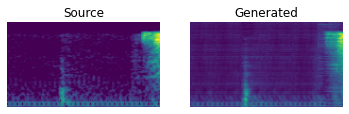

Mean D loss: 0.46350419521331787 Mean G loss: 0.6824982762336731 Mean ID loss: 0.11164423823356628
[Epoch 7/20] [Batch 0] [D loss f: 0.46902909874916077 r: 0.7824397683143616] [G loss: 0.671187698841095] [ID loss: 0.10835915803909302] [LR: 0.0002]
[Epoch 7/20] [Batch 600] [D loss f: 0.45115143060684204 r: 0.7746419310569763] [G loss: 0.6949183344841003] [ID loss: 0.10904103517532349] [LR: 0.0002]
[Epoch 7/20] [Batch 1200] [D loss f: 0.47723978757858276 r: 0.7686546444892883] [G loss: 0.6773805022239685] [ID loss: 0.10863034427165985] [LR: 0.0002]
[Epoch 7/20] [Batch 1800] [D loss f: 0.461019903421402 r: 0.7690140604972839] [G loss: 0.6801233887672424] [ID loss: 0.11407994478940964] [LR: 0.0002]


  0%|          | 0/2000 [00:00<?, ?it/s]

Time/Batch 0.03302524650464998
Saving...
(6, 80, 24, 1)


100%|██████████| 2000/2000 [00:04<00:00, 414.51it/s, loss=1.21e-6, spectral_convergence=-15.3]


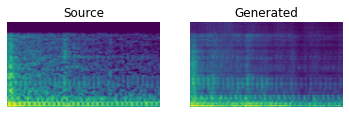

Mean D loss: 0.4678384065628052 Mean G loss: 0.6769140958786011 Mean ID loss: 0.11198701709508896
[Epoch 8/20] [Batch 0] [D loss f: 0.49508148431777954 r: 0.7856559157371521] [G loss: 0.6353586316108704] [ID loss: 0.12026996165513992] [LR: 0.0002]
[Epoch 8/20] [Batch 600] [D loss f: 0.463130384683609 r: 0.8057804107666016] [G loss: 0.6734957695007324] [ID loss: 0.11107748746871948] [LR: 0.0002]
[Epoch 8/20] [Batch 1200] [D loss f: 0.4838835597038269 r: 0.782971978187561] [G loss: 0.7028456330299377] [ID loss: 0.11252271384000778] [LR: 0.0002]
[Epoch 8/20] [Batch 1800] [D loss f: 0.498635858297348 r: 0.7959774732589722] [G loss: 0.645792543888092] [ID loss: 0.1129666417837143] [LR: 0.0002]


  0%|          | 0/2000 [00:00<?, ?it/s]

Time/Batch 0.0330401385481737
Saving...
(6, 80, 24, 1)


100%|██████████| 2000/2000 [00:04<00:00, 401.54it/s, loss=2.62e-7, spectral_convergence=-4.06]


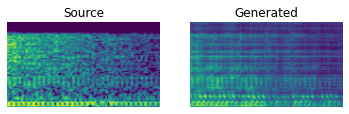

Mean D loss: 0.47889071702957153 Mean G loss: 0.6802074313163757 Mean ID loss: 0.11189013719558716
[Epoch 9/20] [Batch 0] [D loss f: 0.46162939071655273 r: 0.7690200209617615] [G loss: 0.7155401110649109] [ID loss: 0.11008867621421814] [LR: 0.0002]
[Epoch 9/20] [Batch 600] [D loss f: 0.477294921875 r: 0.7810570001602173] [G loss: 0.6803960800170898] [ID loss: 0.10644467175006866] [LR: 0.0002]
[Epoch 9/20] [Batch 1200] [D loss f: 0.48228707909584045 r: 0.8032582402229309] [G loss: 0.6781059503555298] [ID loss: 0.11160001158714294] [LR: 0.0002]
[Epoch 9/20] [Batch 1800] [D loss f: 0.44240233302116394 r: 0.7516990900039673] [G loss: 0.7037039399147034] [ID loss: 0.11067601293325424] [LR: 0.0002]


  0%|          | 0/2000 [00:00<?, ?it/s]

Time/Batch 0.033024229176537155
Saving...
(6, 80, 24, 1)


100%|██████████| 2000/2000 [00:04<00:00, 408.83it/s, loss=0.000438, spectral_convergence=-22.2]


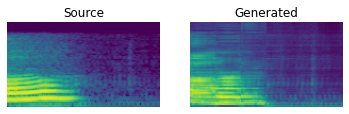

Mean D loss: 0.46805861592292786 Mean G loss: 0.690457820892334 Mean ID loss: 0.10931049287319183
[Epoch 10/20] [Batch 0] [D loss f: 0.47304239869117737 r: 0.7785219550132751] [G loss: 0.7077521085739136] [ID loss: 0.10782667994499207] [LR: 0.0002]
[Epoch 10/20] [Batch 600] [D loss f: 0.46861210465431213 r: 0.791786789894104] [G loss: 0.6770373582839966] [ID loss: 0.10666408389806747] [LR: 0.0002]
[Epoch 10/20] [Batch 1200] [D loss f: 0.46249258518218994 r: 0.7916207313537598] [G loss: 0.6754274368286133] [ID loss: 0.10894370079040527] [LR: 0.0002]
[Epoch 10/20] [Batch 1800] [D loss f: 0.47496867179870605 r: 0.7948628664016724] [G loss: 0.642909824848175] [ID loss: 0.11095934361219406] [LR: 0.0002]


  0%|          | 0/2000 [00:00<?, ?it/s]

Time/Batch 0.03303439838019799
Saving...
(6, 80, 24, 1)


100%|██████████| 2000/2000 [00:04<00:00, 400.47it/s, loss=7.63e-8, spectral_convergence=2.86]


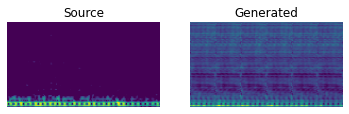

Mean D loss: 0.47092047333717346 Mean G loss: 0.6562967300415039 Mean ID loss: 0.10876867920160294
[Epoch 11/20] [Batch 0] [D loss f: 0.48386797308921814 r: 0.8198477029800415] [G loss: 0.6046196222305298] [ID loss: 0.10828005522489548] [LR: 0.0002]
[Epoch 11/20] [Batch 600] [D loss f: 0.48153799772262573 r: 0.8101263642311096] [G loss: 0.6668908596038818] [ID loss: 0.11013323813676834] [LR: 0.0002]
[Epoch 11/20] [Batch 1200] [D loss f: 0.47598448395729065 r: 0.8057906031608582] [G loss: 0.6593400835990906] [ID loss: 0.11183377355337143] [LR: 0.0002]
[Epoch 11/20] [Batch 1800] [D loss f: 0.47187259793281555 r: 0.8182777166366577] [G loss: 0.645038366317749] [ID loss: 0.11221388727426529] [LR: 0.0002]


  0%|          | 0/2000 [00:00<?, ?it/s]

Time/Batch 0.032996424926431615
Saving...
(6, 80, 24, 1)


100%|██████████| 2000/2000 [00:04<00:00, 411.67it/s, loss=2.08e-7, spectral_convergence=-1.58]


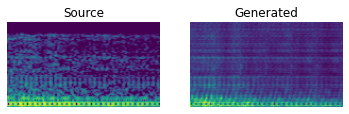

Mean D loss: 0.478532075881958 Mean G loss: 0.6551159620285034 Mean ID loss: 0.11132260411977768
[Epoch 12/20] [Batch 0] [D loss f: 0.49133753776550293 r: 0.8155593276023865] [G loss: 0.6427448987960815] [ID loss: 0.11087961494922638] [LR: 0.0002]
[Epoch 12/20] [Batch 600] [D loss f: 0.4753051698207855 r: 0.8122407793998718] [G loss: 0.6661105155944824] [ID loss: 0.10815492272377014] [LR: 0.0002]
[Epoch 12/20] [Batch 1200] [D loss f: 0.4815260171890259 r: 0.8193650841712952] [G loss: 0.6562585830688477] [ID loss: 0.11051212251186371] [LR: 0.0002]
[Epoch 12/20] [Batch 1800] [D loss f: 0.4934803247451782 r: 0.8123083710670471] [G loss: 0.6246954798698425] [ID loss: 0.10939472168684006] [LR: 0.0002]


  0%|          | 0/2000 [00:00<?, ?it/s]

Time/Batch 0.0329870000870947
Saving...
(6, 80, 24, 1)


100%|██████████| 2000/2000 [00:04<00:00, 402.80it/s, loss=3.76e-8, spectral_convergence=4.81]


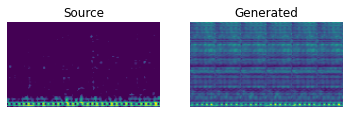

Mean D loss: 0.4822863042354584 Mean G loss: 0.6498160362243652 Mean ID loss: 0.10933644324541092
[Epoch 13/20] [Batch 0] [D loss f: 0.4749421775341034 r: 0.8066062927246094] [G loss: 0.6550538539886475] [ID loss: 0.10934465378522873] [LR: 0.0002]
[Epoch 13/20] [Batch 600] [D loss f: 0.48708853125572205 r: 0.8248248100280762] [G loss: 0.6032238602638245] [ID loss: 0.11177744716405869] [LR: 0.0002]
[Epoch 13/20] [Batch 1200] [D loss f: 0.48331552743911743 r: 0.8070573806762695] [G loss: 0.6309486031532288] [ID loss: 0.11002693325281143] [LR: 0.0002]
[Epoch 13/20] [Batch 1800] [D loss f: 0.468692421913147 r: 0.8313528299331665] [G loss: 0.6726226210594177] [ID loss: 0.10734410583972931] [LR: 0.0002]
Time/Batch 0.03301080807937296
Saving...
(6, 80, 24, 1)


100%|██████████| 2000/2000 [00:04<00:00, 406.48it/s, loss=2.33e-7, spectral_convergence=-3.24]


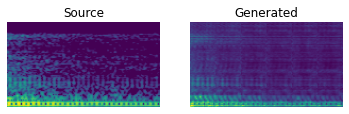

Mean D loss: 0.4820970296859741 Mean G loss: 0.6261997222900391 Mean ID loss: 0.10995651036500931
[Epoch 14/20] [Batch 0] [D loss f: 0.4977744221687317 r: 0.8157699704170227] [G loss: 0.569343090057373] [ID loss: 0.11122746020555496] [LR: 0.0002]
[Epoch 14/20] [Batch 600] [D loss f: 0.4843641221523285 r: 0.8201857209205627] [G loss: 0.6410441994667053] [ID loss: 0.10707445442676544] [LR: 0.0002]
[Epoch 14/20] [Batch 1200] [D loss f: 0.4724002182483673 r: 0.8289950489997864] [G loss: 0.6281999945640564] [ID loss: 0.11050170660018921] [LR: 0.0002]
[Epoch 14/20] [Batch 1800] [D loss f: 0.47124654054641724 r: 0.8178191184997559] [G loss: 0.6410264372825623] [ID loss: 0.10853853821754456] [LR: 0.0002]


  0%|          | 0/2000 [00:00<?, ?it/s, loss=2.07e-6, spectral_convergence=-1.78]

Time/Batch 0.03298752392839083
Saving...
(6, 80, 24, 1)


100%|██████████| 2000/2000 [00:05<00:00, 384.42it/s, loss=5.2e-7, spectral_convergence=-7.31]


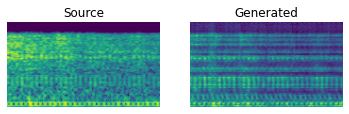

Mean D loss: 0.47523775696754456 Mean G loss: 0.6336797475814819 Mean ID loss: 0.10894127935171127
[Epoch 15/20] [Batch 0] [D loss f: 0.4686826467514038 r: 0.8161430358886719] [G loss: 0.6179227232933044] [ID loss: 0.11040905863046646] [LR: 0.0002]
[Epoch 15/20] [Batch 600] [D loss f: 0.4881467819213867 r: 0.8293870091438293] [G loss: 0.6161321997642517] [ID loss: 0.10851652920246124] [LR: 0.0002]
[Epoch 15/20] [Batch 1200] [D loss f: 0.4842073619365692 r: 0.8369314670562744] [G loss: 0.6330690383911133] [ID loss: 0.10935315489768982] [LR: 0.0002]
[Epoch 15/20] [Batch 1800] [D loss f: 0.4738911986351013 r: 0.8295389413833618] [G loss: 0.6520866751670837] [ID loss: 0.1067955270409584] [LR: 0.0002]


  0%|          | 0/2000 [00:00<?, ?it/s]

Time/Batch 0.033133914181852
Saving...
(6, 80, 24, 1)


100%|██████████| 2000/2000 [00:05<00:00, 376.79it/s, loss=2.97e-7, spectral_convergence=-3.5]


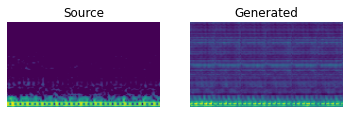

Mean D loss: 0.48170608282089233 Mean G loss: 0.635857880115509 Mean ID loss: 0.1076628640294075
[Epoch 16/20] [Batch 0] [D loss f: 0.47957056760787964 r: 0.8397988677024841] [G loss: 0.6478733420372009] [ID loss: 0.10441826283931732] [LR: 0.0002]
[Epoch 16/20] [Batch 600] [D loss f: 0.49280279874801636 r: 0.8113418221473694] [G loss: 0.6268173456192017] [ID loss: 0.10837750881910324] [LR: 0.0002]
[Epoch 16/20] [Batch 1200] [D loss f: 0.48356306552886963 r: 0.8300357460975647] [G loss: 0.6335750222206116] [ID loss: 0.10285215079784393] [LR: 0.0002]
[Epoch 16/20] [Batch 1800] [D loss f: 0.4882846474647522 r: 0.8324166536331177] [G loss: 0.6276388168334961] [ID loss: 0.10881029814481735] [LR: 0.0002]


  0%|          | 0/2000 [00:00<?, ?it/s]

Time/Batch 0.0329920469723518
Saving...
(6, 80, 24, 1)


100%|██████████| 2000/2000 [00:05<00:00, 376.95it/s, loss=8.63e-7, spectral_convergence=-11.8]


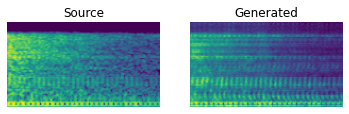

Mean D loss: 0.4883809983730316 Mean G loss: 0.6244987845420837 Mean ID loss: 0.10639398545026779
[Epoch 17/20] [Batch 0] [D loss f: 0.4893777370452881 r: 0.837799072265625] [G loss: 0.5959880352020264] [ID loss: 0.10470453649759293] [LR: 0.0002]
[Epoch 17/20] [Batch 600] [D loss f: 0.47066381573677063 r: 0.8440059423446655] [G loss: 0.6390491724014282] [ID loss: 0.1043514832854271] [LR: 0.0002]
[Epoch 17/20] [Batch 1200] [D loss f: 0.487875372171402 r: 0.8101180791854858] [G loss: 0.6062705516815186] [ID loss: 0.10716371983289719] [LR: 0.0002]
[Epoch 17/20] [Batch 1800] [D loss f: 0.4898763597011566 r: 0.822450578212738] [G loss: 0.6313005089759827] [ID loss: 0.10224703699350357] [LR: 0.0002]


  0%|          | 0/2000 [00:00<?, ?it/s]

Time/Batch 0.033080806075252434
Saving...
(6, 80, 24, 1)


100%|██████████| 2000/2000 [00:05<00:00, 381.48it/s, loss=4.33e-7, spectral_convergence=-6.58]


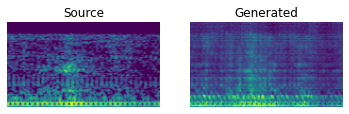

Mean D loss: 0.48252469301223755 Mean G loss: 0.6331456899642944 Mean ID loss: 0.10486108809709549
[Epoch 18/20] [Batch 0] [D loss f: 0.4808627963066101 r: 0.8099731802940369] [G loss: 0.6778185367584229] [ID loss: 0.10637876391410828] [LR: 0.0002]
[Epoch 18/20] [Batch 600] [D loss f: 0.4802940785884857 r: 0.8041990399360657] [G loss: 0.6418604254722595] [ID loss: 0.10454431921243668] [LR: 0.0002]
[Epoch 18/20] [Batch 1200] [D loss f: 0.4825909435749054 r: 0.822587251663208] [G loss: 0.6351092457771301] [ID loss: 0.1029345691204071] [LR: 0.0002]
[Epoch 18/20] [Batch 1800] [D loss f: 0.492010235786438 r: 0.8254454731941223] [G loss: 0.5978445410728455] [ID loss: 0.10629179328680038] [LR: 0.0002]


  0%|          | 0/2000 [00:00<?, ?it/s]

Time/Batch 0.03313450269631139
Saving...
(6, 80, 24, 1)


100%|██████████| 2000/2000 [00:04<00:00, 406.09it/s, loss=0.000126, spectral_convergence=-34.2]


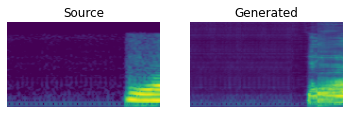

Mean D loss: 0.48644718527793884 Mean G loss: 0.6208866834640503 Mean ID loss: 0.10420631617307663
[Epoch 19/20] [Batch 0] [D loss f: 0.4955456256866455 r: 0.8328818678855896] [G loss: 0.5966917276382446] [ID loss: 0.10199571400880814] [LR: 0.0002]
[Epoch 19/20] [Batch 600] [D loss f: 0.49448898434638977 r: 0.8282574415206909] [G loss: 0.6168150901794434] [ID loss: 0.1054062619805336] [LR: 0.0002]
[Epoch 19/20] [Batch 1200] [D loss f: 0.4874928891658783 r: 0.8425112962722778] [G loss: 0.6327124238014221] [ID loss: 0.10217700898647308] [LR: 0.0002]
[Epoch 19/20] [Batch 1800] [D loss f: 0.47557586431503296 r: 0.833665668964386] [G loss: 0.6246866583824158] [ID loss: 0.10510724782943726] [LR: 0.0002]


  0%|          | 0/2000 [00:00<?, ?it/s]

Time/Batch 0.03315291325440033
Saving...
(6, 80, 24, 1)


100%|██████████| 2000/2000 [00:04<00:00, 400.33it/s, loss=2.63e-7, spectral_convergence=-4.64]


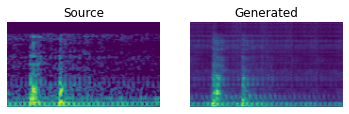

Mean D loss: 0.47845882177352905 Mean G loss: 0.6399970054626465 Mean ID loss: 0.10407840460538864


In [ ]:
#Training

#n_save = how many epochs between each saving and displaying of results
#gupt = how many discriminator updates for generator+siamese update

train(20, batch_size=bs, lr=0.0002, n_save=1, gupt=3)

In [ ]:
#After Training, use these functions to convert data with the generator and save the results

#Assembling generated Spectrogram chunks into final Spectrogram
def specass(a,spec):
  but=False
  con = np.array([])
  nim = a.shape[0]
  for i in range(nim-1):
    im = a[i]
    im = np.squeeze(im)
    if not but:
      con=im
      but=True
    else:
      con = np.concatenate((con,im), axis=1)
  diff = spec.shape[1]-(nim*shape)
  a = np.squeeze(a)
  con = np.concatenate((con,a[-1,:,-diff:]), axis=1)
  return np.squeeze(con)

#Splitting input spectrogram into different chunks to feed to the generator
def chopspec(spec):
  dsa=[]
  for i in range(spec.shape[1]//shape):
    im = spec[:,i*shape:i*shape+shape]
    im = np.reshape(im, (im.shape[0],im.shape[1],1))
    dsa.append(im)
  imlast = spec[:,-shape:]
  imlast = np.reshape(imlast, (imlast.shape[0],imlast.shape[1],1))
  print(imlast.shape)
  dsa.append(imlast)
  print(np.array(dsa, dtype=np.float32).shape)
  for i in np.array(dsa, dtype=np.float32):
    for elem in i:
      np.concatenate((elem, target_m01_vector), axis=0)
  
  print(np.array(dsa, dtype=np.float32)[-1])
  return np.array(dsa, dtype=np.float32)

#Converting from source Spectrogram to target Spectrogram
def towave(spec, name, path='../content/', show=False):
  specarr = chopspec(spec)
  print(specarr.shape)
  a = specarr
  print('Generating...')
  ab = gen(a, training=False)
  print('Assembling and Converting...')
  a = specass(a,spec)
  ab = specass(ab,spec)
  awv = deprep(a)
  abwv = deprep(ab)
  print('Saving...')
  pathfin = f'{path}/{name}'
  os.mkdir(pathfin)
  sf.write(pathfin+'/AB.wav', abwv, sr)
  sf.write(pathfin+'/A.wav', awv, sr)
  print('Saved WAV!')
  IPython.display.display(IPython.display.Audio(np.squeeze(abwv), rate=sr))
  IPython.display.display(IPython.display.Audio(np.squeeze(awv), rate=sr))
  if show:
    fig, axs = plt.subplots(ncols=2)
    axs[0].imshow(np.flip(a, -2), cmap=None)
    axs[0].axis('off')
    axs[0].set_title('Source')
    axs[1].imshow(np.flip(ab, -2), cmap=None)
    axs[1].axis('off')
    axs[1].set_title('Generated')
    plt.show()
  return abwv

In [ ]:
print(f03_final_emb[0])
print(f01_final_embedding[0])

[-0.01790073]
[0.04897482]


In [ ]:
f01_code= '[0.04897482]'
f03_code = '[-0.01790073]'
m01_code = m01_final_embed[0]
print(m01_code)

[0.04834156]


In [ ]:
def create_target_vector(speaker_index):
  speaker_vector = np.full((240, 1), speaker_index)
  return speaker_vector 

target_f01_vector = np.full((24, 1), 0.04897482 )
target_f02_vector = np.full((24, 1),-0.01790073 )
target_m01_vector = np.full((24, 1),0.04834156 )

print(target_f01_vector)


[[0.04897482]
 [0.04897482]
 [0.04897482]
 [0.04897482]
 [0.04897482]
 [0.04897482]
 [0.04897482]
 [0.04897482]
 [0.04897482]
 [0.04897482]
 [0.04897482]
 [0.04897482]
 [0.04897482]
 [0.04897482]
 [0.04897482]
 [0.04897482]
 [0.04897482]
 [0.04897482]
 [0.04897482]
 [0.04897482]
 [0.04897482]
 [0.04897482]
 [0.04897482]
 [0.04897482]]


(167139,)


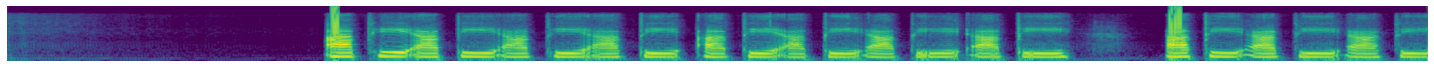

(80, 24, 1)
(88, 80, 24, 1)
[[[ 0.16288805]
  [ 0.14476275]
  [ 0.19386363]
  ...
  [ 0.0656209 ]
  [ 0.28642273]
  [ 0.3511864 ]]

 [[ 0.29711306]
  [ 0.27898777]
  [ 0.32808864]
  ...
  [ 0.19984591]
  [ 0.42064786]
  [ 0.4854114 ]]

 [[ 0.0931375 ]
  [ 0.24835253]
  [ 0.11370289]
  ...
  [ 0.13769484]
  [ 0.42452824]
  [ 0.5122665 ]]

 ...

 [[-0.80742675]
  [-0.80742675]
  [-0.80742675]
  ...
  [-0.63712996]
  [-0.39141345]
  [-0.3168326 ]]

 [[-0.80742675]
  [-0.80742675]
  [-0.80742675]
  ...
  [-0.5831735 ]
  [-0.34034348]
  [-0.26610708]]

 [[-0.80742675]
  [-0.80742675]
  [-0.80742675]
  ...
  [-0.61481535]
  [-0.37894106]
  [-0.30554807]]]
(88, 80, 24, 1)
Generating...
Assembling and Converting...


100%|██████████| 2000/2000 [00:04<00:00, 419.72it/s, loss=0.025, spectral_convergence=-11.3]


Saving...
Saved WAV!


In [ ]:
#Wav to wav conversion

wv, sr = librosa.load('/content/INP/FC01_10002.wav', sr=22050)  #Load waveform
print(wv.shape)
speca = prep(wv)                                                    #Waveform to Spectrogram

plt.figure(figsize=(50,1))                                          #Show Spectrogram
plt.imshow(np.flip(speca, axis=0), cmap=None)
plt.axis('off')
plt.show()

abwv = towave(speca, name='FILENAME13', path='../content/')           #Convert and save wav